In [417]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import csv

from astropy import units as u
from astropy.coordinates import Angle, Galactic, SkyCoord
from astropy.io import fits

from regions import CircleSkyRegion

%matplotlib inline

### Where is the PLATO LOPS2 zone in comparison with the TESS continuous viewing zone?

In [302]:
# https://www.cosmos.esa.int/web/plato/first-sky-field
PLATO_LOPS2_ZONE_CENTRE = np.array([255.9375, -24.62432])  # galatic longitude, latitude
BOUND = 24.5  # degrees from centre representing the bound of the LOPS2 viewing area

In [130]:
PLATO_LOPS2_ZONE_BOUNDS = np.array([
    [255.9375+BOUND, -24.62432+BOUND],
    [255.9375+BOUND, -24.62432-BOUND],
    [255.9375-BOUND, -24.62432+BOUND],
    [255.9375-BOUND, -24.62432-BOUND],
])

In [131]:
lops2 = Galactic(l=PLATO_LOPS2_ZONE_BOUNDS[:, 0]*u.degree, b=PLATO_LOPS2_ZONE_BOUNDS[:, 1]*u.degree)
tess_cvz = SkyCoord(lon=0*u.degree, lat=-90*u.degree, frame='geocentricmeanecliptic').transform_to('galactic')

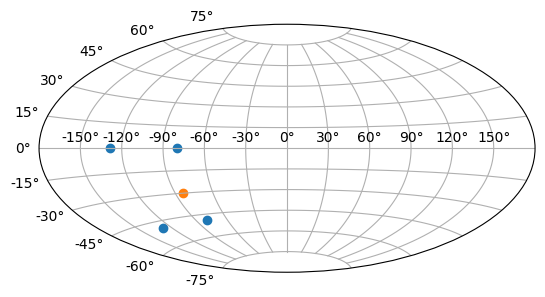

In [132]:
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian)
plt.scatter(tess_cvz.l.wrap_at('180d').radian, tess_cvz.b.radian)

Note the TESS continuous viewing zone centre (orange) is at the ecliptic pole. This is around 60 degrees offset from the galactic pole.

### Which PLATO input catalogue stars are in LOPS2?

In [133]:
# https://archive.stsci.edu/hlsp/aspic
hdul = fits.open('~/Downloads/hlsp_aspic_gaia_astrometric-photometric_all-sky_multi_v1.1_cat.fits')
hdul.info()

Filename: /Users/lawrence/Downloads/hlsp_aspic_gaia_astrometric-photometric_all-sky_multi_v1.1_cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    225   2675539R x 70C   [1K, 16A, 1K, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1D, 1J, 1D, 1J, 1D, 1J]   


In [134]:
hdul[1].columns

ColDefs(
    name = 'PICidDR1'; format = '1K'; null = -99; dim = '(1)'
    name = 'PICnameDR1'; format = '16A'; dim = '(1)'
    name = 'sourceId'; format = '1K'; null = -99; dim = '(1)'
    name = 'RAdeg'; format = '1D'; dim = '(1)'
    name = 'eRAdeg'; format = '1D'; dim = '(1)'
    name = 'DEdeg'; format = '1D'; dim = '(1)'
    name = 'eDEdeg'; format = '1D'; dim = '(1)'
    name = 'Plx'; format = '1D'; dim = '(1)'
    name = 'ePlx'; format = '1D'; dim = '(1)'
    name = 'pmRA'; format = '1D'; dim = '(1)'
    name = 'epmRA'; format = '1D'; dim = '(1)'
    name = 'pmDE'; format = '1D'; dim = '(1)'
    name = 'epmDE'; format = '1D'; dim = '(1)'
    name = 'PM'; format = '1D'; dim = '(1)'
    name = 'ePM'; format = '1D'; dim = '(1)'
    name = 'Epoch'; format = '1D'; dim = '(1)'
    name = 'Gflux'; format = '1D'; dim = '(1)'
    name = 'eGflux'; format = '1D'; dim = '(1)'
    name = 'Gmag'; format = '1D'; dim = '(1)'
    name = 'eGmag'; format = '1D'; dim = '(1)'
    name = 'BPflux'; fo

In [143]:
PLATO_LOPS2_CENTRE_LON = 255.9375
PLATO_LOPS2_CENTRE_LAT = -24.62432
BOUND = 24.5  # degrees from centre representing the bound of the LOPS2 viewing area

In [155]:
# sourceId: Gaia DR2 sourceId
# ELON: galactic longitude
# ELAT: galactic latitude

def is_in_lops2(elon, elat):
    return (PLATO_LOPS2_CENTRE_LON-BOUND < elon and elon < PLATO_LOPS2_CENTRE_LON+BOUND) \
    and (PLATO_LOPS2_CENTRE_LAT-BOUND < elat and elat < PLATO_LOPS2_CENTRE_LAT+BOUND)

lops2_stars = []
for star in tqdm(hdul[1].data):
    source_id = star.field("sourceId")[0]
    elon = star.field("ELON")[0]
    elat = star.field("ELAT")[0]
    if is_in_lops2(elon, elat):
        lops2_stars.append(source_id)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2675539/2675539 [04:39<00:00, 9569.67it/s]


In [156]:
len(lops2_stars)

197621

There are around 200k targets in the LOPS2 zone.

In [161]:
pd.Series(lops2_stars).rename("GAIA DR2 sourceId").to_csv("./results/18_plato_lops2_stars.csv")

### How many of these targets have been previously observed by TESS?

In [309]:
list(pd.read_csv("~/Downloads/exo_CTL_08.01xTIC_v8.1_header.csv").columns)

['[ID]:Integer',
 '[version]:String',
 '[HIP]:Integer',
 '[TYC]:String',
 '[UCAC]:String',
 '[TWOMASS]:String',
 '[SDSS]:Integer',
 '[ALLWISE]:String',
 '[GAIA]:String',
 '[APASS]:String',
 '[KIC]:Integer',
 '[objType]:String',
 '[typeSrc]:String',
 '[ra]:Float',
 '[dec]:Float',
 '[POSflag]:String',
 '[pmRA]:Float',
 '[e_pmRA]:Float',
 '[pmDEC]:Float',
 '[e_pmDEC]:Float',
 '[PMflag]:String',
 '[plx]:Float',
 '[e_plx]:Float',
 '[PARflag]:String',
 '[gallong]:Float',
 '[gallat]:Float',
 '[eclong]:Float',
 '[eclat]:Float',
 '[Bmag]:Float',
 '[e_Bmag]:Float',
 '[Vmag]:Float',
 '[e_Vmag]:Float',
 '[umag]:Float',
 '[e_umag]:Float',
 '[gmag]:Float',
 '[e_gmag]:Float',
 '[rmag]:Float',
 '[e_rmag]:Float',
 '[imag]:Float',
 '[e_imag]:Float',
 '[zmag]:Float',
 '[e_zmag]:Float',
 '[Jmag]:Float',
 '[e_Jmag]:Float',
 '[Hmag]:Float',
 '[e_Hmag]:Float',
 '[Kmag]:Float',
 '[e_Kmag]:Float',
 '[TWOMflag]:String',
 '[prox]:Float',
 '[w1mag]:Float',
 '[e_w1mag]:Float',
 '[w2mag]:Float',
 '[e_w2mag]:Float',

In [334]:
TARGET_TICS = []
for sector in tqdm(range(1, 81)): 
    df = pd.read_csv(f"https://tess.mit.edu/public/target_lists/2m/all_targets_S{sector:>03}_v1.csv", header=5, on_bad_lines="skip")
    TARGET_TICS += list(df.TICID)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:12<00:00,  1.11it/s]


In [335]:
for sector in tqdm(range(27, 81)): 
    df = pd.read_csv(f"https://tess.mit.edu/public/target_lists/20s/all_targets_20s_S{sector:>03}_v1.csv", header=5, on_bad_lines="skip")
    TARGET_TICS += list(df.TICID)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:24<00:00,  2.18it/s]


In [341]:
TARGET_TICS = set(TARGET_TICS)

In [343]:
TARGET_GAIA_IDS = []
with open("/Users/lawrence/Downloads/exo_CTL_08.01xTIC_v8.1.csv") as f:
    reader = csv.DictReader(f, fieldnames=list(pd.read_csv("~/Downloads/exo_CTL_08.01xTIC_v8.1_header.csv").columns))
    for row in tqdm(reader):
        try:
            tic_id = int(row['[ID]:Integer'])
            gaia_id = int(row['[GAIA]:String'])
            if tic_id in TARGET_TICS:
                TARGET_GAIA_IDS.append(gaia_id)
        except:
            pass

9488282it [05:16, 30008.26it/s]


In [344]:
len(TARGET_GAIA_IDS)

391601

In [346]:
len(set(TARGET_GAIA_IDS) & set(lops2_stars))

11380

There are 11380 stars that have previously been observed by TESS at the 2 minute or 20 second cadences.

### How many of these targets have been previously identified as containing an transiting planet?

In [249]:
def load_data(path):
    metadata = []
    with open(path) as f:
        header = 0
        while True:
            line = next(f)
            if line.startswith("#"):
                metadata.append(line)
                header += 1
            else:
                break
                
    column_name_map = {k: v for k, v in re.findall("COLUMN\s+(\w+):\s+([^,]+)", "".join(metadata))}
    df = pd.read_csv(path, skiprows=header, low_memory=False)
    df = df.rename(columns=column_name_map)

    return df
    
df = load_data("./data/NASA/planetary_systems_composite.csv")
len(df.index)

5241

In [240]:
is_dr2_id = df["GAIA ID"].astype(str).str.startswith("Gaia DR2")
is_dr2_id.sum()

5028

In [244]:
dr2_ids = df["GAIA ID"][is_dr2_id]
in_lops2_zone = dr2_ids.str.replace("Gaia DR2", "").astype(int).isin(lops2_stars)
in_lops2_zone.sum()

86

There are 86 known transiting planets in the PLATO LOPS2 zone.

### How many of these targets are in my current working sample?

In [369]:
results = pd.read_csv("./results/14_results_df.csv")

In [371]:
in_lops_2 = results["GAIA ID"].str.replace("Gaia DR2 ", "").astype(int).isin(lops2_stars)
lops2_stars_of_interest = results[in_lops_2].copy()
lops2_stars_of_interest

,planet,planet.1,num_transits,mu,sd,prob_decay,rowid,Host Name,Planet Letter,HD ID,...,-da/dt [m/s],-dP/dt [s/s],-dP/dE [s/epoch],TTV after 10 years [s],-dP/dE [ms/epoch],-dP/dE error [ms/epoch],observed_dP_dE_ms,error_observed_dP_dE_ms,theoretical_dP_dE_ms,error_theoretical_dP_dE_ms
91,hats24,hats24,50,0.036166,0.078438,0.320042,389,HATS-24,b,NaN,...,2.875851e-06,1.356990e-10,1.581031e-05,57.915622,0.015810,0.009809,0.000000,0.078438,0.015810,0.009809
96,hats29,hats29,5,1.285154,9.998294,0.440037,394,HATS-29,b,NaN,...,6.898167e-09,5.031769e-13,2.002381e-07,0.062875,0.000200,0.000115,0.000000,9.998294,0.000200,0.000115
171,k2237,k2237,35,0.390828,0.560913,0.239009,1456,K2-237,b,NaN,...,3.154724e-07,1.677230e-11,3.159872e-06,4.426893,0.003160,0.001797,0.000000,0.560913,0.003160,0.001797
179,k231,k231,10,0.084014,0.187461,0.315009,1545,K2-31,b,NaN,...,6.180365e-07,3.040313e-11,3.304159e-06,13.911019,0.003304,0.003356,0.000000,0.187461,0.003304,0.003356
285,toi824,toi824,22,-8.970693,20.896574,0.671278,4951,TOI-824,b,NaN,...,1.413429e-08,7.830467e-13,9.424225e-08,0.323529,0.000094,0.000054,8.970693,20.896574,0.000094,0.000054
354,wasp192,wasp192,14,0.572987,2.270896,0.395030,5085,WASP-192,b,NaN,...,3.401624e-07,2.082172e-11,5.178730e-06,4.162874,0.005179,0.003129,0.000000,2.270896,0.005179,0.003129


In [198]:
lops2_stars_of_interest[[
     'planet',
     'Number of Planets',
     'num_transits',
     'prob_decay',
     'TTV after 10 years [s]',
     'observed_dP_dE_ms',
     'error_observed_dP_dE_ms',
     'theoretical_dP_dE_ms',
     'error_theoretical_dP_dE_ms'
    ]
]

,planet,Number of Planets,num_transits,prob_decay,TTV after 10 years [s],observed_dP_dE_ms,error_observed_dP_dE_ms,theoretical_dP_dE_ms,error_theoretical_dP_dE_ms
91,hats24,1,50,0.320042,57.915622,0.000000,0.078438,0.015810,0.009809
96,hats29,1,5,0.440037,0.062875,0.000000,9.998294,0.000200,0.000115
171,k2237,1,35,0.239009,4.426893,0.000000,0.560913,0.003160,0.001797
179,k231,1,10,0.315009,13.911019,0.000000,0.187461,0.003304,0.003356
285,toi824,1,22,0.671278,0.323529,8.970693,20.896574,0.000094,0.000054
354,wasp192,1,14,0.395030,4.162874,0.000000,2.270896,0.005179,0.003129


6 of these 86 planets are in my transits dataset. (The others likely do not have pre-fitted lightcurves available - I could expand to this dataset in future.)

### How much will the additional PLATO observations (assuming a two year observation duration) improve our observational uncertainty?

In [294]:
list(lops2_stars_of_interest.columns)

['planet',
 'planet.1',
 'num_transits',
 'mu',
 'sd',
 'prob_decay',
 'rowid',
 'Host Name',
 'Planet Letter',
 'HD ID',
 'HIP ID',
 'TIC ID',
 'GAIA ID',
 'Number of Stars',
 'Number of Planets',
 'Number of Moons',
 'Circumbinary Flag',
 'Discovery Method',
 'Discovery Year',
 'Discovery Reference',
 'Discovery Publication Date',
 'Discovery Locale',
 'Discovery Facility',
 'Discovery Telescope',
 'Discovery Instrument',
 'Detected by Radial Velocity Variations',
 'Detected by Pulsar Timing Variations',
 'Detected by Pulsation Timing Variations',
 'Detected by Transits',
 'Detected by Astrometric Variations',
 'Detected by Orbital Brightness Modulations',
 'Detected by Microlensing',
 'Detected by Eclipse Timing Variations',
 'Detected by Imaging',
 'Detected by Disk Kinematics',
 'Controversial Flag',
 'Orbital Period [days]',
 'Orbital Period Upper Unc. [days]',
 'Orbital Period Lower Unc. [days]',
 'Orbital Period Limit Flag',
 'Orbital Period Reference',
 'Orbit Semi-Major Axis 

In [374]:
number_of_transits = (365*2 / lops2_stars_of_interest['Orbital Period [days]']).astype(int)
lops2_stars_of_interest['number_of_plato_transits'] = number_of_transits
lops2_stars_of_interest['number_of_plato_transits']

91     541
96     158
171    334
179    580
285    524
354    253
Name: number_of_plato_transits, dtype: int64

Given PLATO has a sampling cadence of 25s, the transit mid time uncertainty will be at least on the order of 25s, not accounting for how noise will affect light curve modelling. Let's assume a 1 sigma uncertainty of 300s for now.

_Question: how can we improve this estimate?_

In [489]:
UNCERTAINTY_SD = 300*1e3  # ms

Applying Bayes rule for Gaussian multivariate distributions with fixed uncertainty per observation:

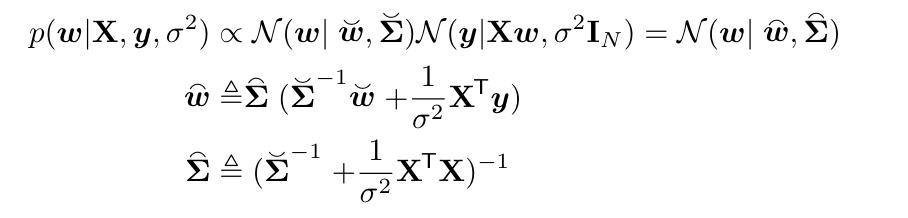

Assume a PLATO start date of Jan 2027.

In [398]:
from astropy.time import Time

PLATO_START_DATE_JD = Time('2027-01-01T00:00:00', format='isot', scale='utc').to_value('jd')
PLATO_START_DATE_JD

2461406.5

In [494]:
def compute_posterior_uncertainty(epochs, uncertainty_sd, prior_covariance_matrix):
    """
    Computes the posterior 1 sigma uncertainty in ms/epoch given new epochs with given uncertainty,
    and a prior covariance matrix.
    """
    X = np.vstack(
        [
            np.power(epochs, 0.0),
            np.power(epochs, 1.0),
            0.5 * np.power(epochs, 2.0),
        ]
    ).T

    posterior_covariance_matrix = np.power((np.power(prior_covariance_matrix, -1.0)) + (np.power(uncertainty_sd, -2.0) * (X.T @ X)), -1.0)
    posterior_uncertainty = np.sqrt(posterior_covariance_matrix[2,2])
    return posterior_uncertainty  # ms/epoch

In [428]:
def bayesian_mvn_regression_fit(df, K0=None):
    """
    An analytical fit based on Bayesian multivariate regression but parameterising both
    the model parameters and observational errors.
    """
    # determine priors on T0 and P0 through a constant period least squares fit
    X = np.vstack(
        [
            np.power(df.epoch, 0.0),
            np.power(df.epoch, 1.0),
            # do not use a decay term
        ]
    ).T
    y = np.atleast_2d(df.transit_time.values).T
    constant_fit_beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    constant_fit_T0 = constant_fit_beta[0].item()
    constant_fit_P0 = constant_fit_beta[1].item()
    beta0 = np.atleast_2d([constant_fit_T0, constant_fit_P0, 0.0]).T

    # determine the precision of our prior on beta
    # 1.0 corresponds to a weighting of 50% in the posterior beta
    # precision on the T0 and P0 terms is equivalent to saying the 1 standard deviation = constant_fit_P0
    # precision on dP/dE is equivalent to saying the 1 standard deviation = 1 ms/epoch i.e. decay on the
    # order of more than a millisecond per epoch is highly unlikely
    ms_in_days = 1e-3 / 60 / 60 / 24
    if K0 is None:
        K0 = np.diag([1 / constant_fit_P0, 1 / constant_fit_P0, 1 / ms_in_days])
    K0_inv = np.linalg.inv(K0)
    I = np.identity(3)

    D = len(df)  # number of dimensions of the covariance matrix

    # we choose a prior degrees of freedom such that the expected value (aka mean) of the prior IW
    # distribution on Σ is S0, the prior covariance matrix given by the data
    v0 = D + 2

    # the prior scatter matrix which is in this case equivalent to prior covariance is just the
    # reported covariance we get from our datasets, adjusted for degrees of freedom
    S0 = np.diagflat(np.power(df.error.values, 2.0)) * (v0 + D + 1)

    X = np.vstack(
        [
            np.power(df.epoch, 0.0),
            np.power(df.epoch, 1.0),
            0.5 * np.power(df.epoch, 2.0),
        ]
    ).T
    y = np.atleast_2d(df.transit_time.values).T
    beta_hat, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

    residuals = y - X @ beta_hat
    Se = residuals @ residuals.T  # empirical scatter matrix

    virtual_residuals = X @ (0.5 * np.linalg.inv(K0_inv + I)) @ (beta_hat - beta0)
    Sv = virtual_residuals @ virtual_residuals.T  # virtual scatter matrix

    beta = np.linalg.inv(K0 + I) @ ((K0 @ beta0) + beta_hat)
    S = S0 + Se + Sv
    v = (
        v0 + 1
    )  # add 1 to the prior degrees of freedom to account for the addition of a single set of observations
    K = (
        K0 + I
    )  # the new belief in our beta also increases by 1 to account for the addition of a single set of observations

    t_sigma = (
        np.linalg.inv(K) @ (np.linalg.inv(X.T @ np.linalg.inv(S) @ X)) / (v + 1 - 3)
    )
    t_dof = v + 1 - 3

    mu = beta[2, 0] * (24 * 60 * 60 * 1000)
    t_sd = np.sqrt(t_sigma[2, 2] * (24 * 60 * 60 * 1000) ** 2)
    posterior_covariance_matrix = t_sigma * (t_dof / (t_dof - 2)) * (24 * 60 * 60 * 1000) ** 2
    sd = np.sqrt(t_sigma[2, 2] * (t_dof / (t_dof - 2)) * (24 * 60 * 60 * 1000) ** 2)
    prob_decay = sp.stats.t.cdf(0, t_dof, mu, t_sd)
    # print(f"E[dP/dE] = {mu} ms/epoch SD[dP/dE] = {sd} Prob(dP/dE < 0) = {prob_decay}")
    posterior_observation_covariance = S / (
        v + len(df) + 1
    )  # the MAP of the IW distribution over Σ
    # Similarly: prior_observation_covariance = S0 / (v0 + len(df) + 1)
    error = np.power(np.diag(posterior_observation_covariance), 0.5)

    k = D + 3
    return (
        beta,
        t_sigma,
        error,
        k,
        t_dof,
        prob_decay,
        posterior_observation_covariance,
        posterior_covariance_matrix,
    )

In [538]:
for planet, transits in transit_df.groupby("planet"):
    print(f"{planet=}")
    *_, posterior_covariance_matrix = bayesian_mvn_regression_fit(transits, K0=np.diag([1e-12, 1e-12, 1e-12]))
    old_posterior_uncertainty = np.sqrt(posterior_covariance_matrix[2,2])

    planet_info = lops2_stars_of_interest.loc[lops2_stars_of_interest.planet == planet].squeeze()
    num_new_transits = planet_info.number_of_plato_transits
    print(f"{num_new_transits=}")

    first_transit = transits.iloc[transits.transit_time.argmin()]
    assert first_transit.epoch == 0.0
    epochs_between_first_obs_and_first_plato_obs = int(((PLATO_START_DATE_JD - first_transit.transit_time) / planet_info["Orbital Period [days]"]))
    new_epochs = epochs_between_first_obs_and_first_plato_obs + np.arange(0, num_new_transits)

    print(f"Assuming PLATO transit mid-time uncertainty of {int(UNCERTAINTY_SD/1000)} s/epoch")
    new_posterior_uncertainty = compute_posterior_uncertainty(new_epochs, UNCERTAINTY_SD, posterior_covariance_matrix)
    improvement = (old_posterior_uncertainty - new_posterior_uncertainty) / old_posterior_uncertainty * 100
    print(f"{old_posterior_uncertainty=:.2f} ms/epoch, {new_posterior_uncertainty=:.2f} ms/epoch")
    print(f"{improvement=:.2f}%")
    print("---------")

planet='hats24'
num_new_transits=541
Assuming PLATO transit mid-time uncertainty of 300 s/epoch
old_posterior_uncertainty=0.08 ms/epoch, new_posterior_uncertainty=0.00 ms/epoch
improvement=97.35%
---------
planet='hats29'
num_new_transits=158
Assuming PLATO transit mid-time uncertainty of 300 s/epoch
old_posterior_uncertainty=10.00 ms/epoch, new_posterior_uncertainty=0.04 ms/epoch
improvement=99.55%
---------
planet='k2237'
num_new_transits=334
Assuming PLATO transit mid-time uncertainty of 300 s/epoch
old_posterior_uncertainty=0.56 ms/epoch, new_posterior_uncertainty=0.01 ms/epoch
improvement=98.37%
---------
planet='k231'
num_new_transits=580
Assuming PLATO transit mid-time uncertainty of 300 s/epoch
old_posterior_uncertainty=0.19 ms/epoch, new_posterior_uncertainty=0.00 ms/epoch
improvement=99.12%
---------
planet='toi824'
num_new_transits=524
Assuming PLATO transit mid-time uncertainty of 300 s/epoch
old_posterior_uncertainty=20.90 ms/epoch, new_posterior_uncertainty=0.01 ms/epoch


Recall that Turner 2020 observes a decay rate for WASP-12 of 0.08 ms/epoch, so 1 sigma uncertainties in the range pf 0.01 ms/epoch is now really within scope for picking up WASP-12 scales of decay.